In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [2]:
cd ../../Data/Genemaps/Significant_Genes

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps/Significant_Genes


In [19]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [20]:
#load in diffmat data
atlas = ants.image_read('/mmfs1/data/pijarj/BC-ORG-Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [21]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [22]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
22


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 22/22 [00:02<00:00, 10.45it/s]


(22, 699)

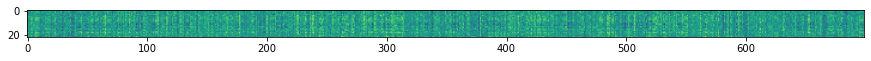

In [24]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)
gene_fmri_corr.shape

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(gene_fmri_corr.transpose())
gene_fmri_corr_PCA = principalComponents

In [26]:
principalComponents.shape

(699, 10)

In [27]:
gene_fmri_corr_PCA.shape

(699, 10)